In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from tqdm import tqdm
import math
from random import sample 
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# def mapping(col):
#     return dict(zip(col.unique(), range(col.nunique())))
# good_foreign_id_to_item_id = mapping(data["good_foreign_id"])
# data["item_id"] = data["good_foreign_id"].map(good_foreign_id_to_item_id)
# data["basket_id"] = data["order_id"].map(mapping(data["order_id"]))

Data Load + EDA: 

In [4]:
df = pd.read_csv('vkusvill_data_20_april.csv')

In [5]:
df.head()

ts      order_id  good_foreign_id
0  2024-04-26 13:43:53.044061  300652819016            83595
1  2024-04-25 12:02:21.705166  300652801623            34835
2  2024-04-27 11:52:32.638244  300652829735            70127
3  2024-04-28 21:25:05.313815  300652850222            31501
4  2024-04-28 15:00:10.870397  300652845460            85447

In [6]:
df['date'] = df.ts.apply(lambda x: x[:10])

In [7]:
gp = pd.DataFrame(df.groupby(['order_id']).agg(list).good_foreign_id).reset_index()

gp.good_foreign_id[gp.good_foreign_id.apply(lambda x: len(x)) == 1] # baskets with a few products - not suitable for the test

10       [83349]
75       [30144]
83       [58467]
85       [54714]
103      [78565]
          ...   
85138    [43762]
85139    [83512]
85156    [15495]
85176    [77072]
85180    [65235]
Name: good_foreign_id, Length: 2292, dtype: object

In [8]:
indexes_to_remove = gp.good_foreign_id[gp.good_foreign_id.apply(lambda x: len(x)) == 1].index.to_list()

In [9]:
df = df.drop(index = indexes_to_remove).reset_index(drop = True)

In [10]:
df.head()

ts      order_id  good_foreign_id        date
0  2024-04-26 13:43:53.044061  300652819016            83595  2024-04-26
1  2024-04-25 12:02:21.705166  300652801623            34835  2024-04-25
2  2024-04-27 11:52:32.638244  300652829735            70127  2024-04-27
3  2024-04-28 21:25:05.313815  300652850222            31501  2024-04-28
4  2024-04-28 15:00:10.870397  300652845460            85447  2024-04-28

In [11]:
df.shape

(626448, 4)

Splitting the data: the train set contains 80% of the items in each basket, and the test set contains the remaining 20%

In [12]:
def split_train_test(group, time_threshold):
    
    train = group[group['date'] <= time_threshold]
    test = group[group['date'] > time_threshold]
    
#     # For test, masking 20% of items
#     test_masked = test.copy()
#     test_masked['masked'] = np.random.choice([True, False], size=len(test), p=[0.2, 0.8])
#     test_masked = test_masked[test_masked['masked']]
    
    return train,test

In [13]:
time_threshold = '2024-04-28'

train_data, test_data = zip(*df.groupby('order_id').apply(split_train_test, 
                                                                 time_threshold=time_threshold))

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

In [14]:
train_data

ts      order_id  good_foreign_id        date
27980   2024-04-20 00:02:54.604473  300652732887            38472  2024-04-20
94829   2024-04-20 00:02:54.604473  300652732887            65528  2024-04-20
118020  2024-04-20 00:02:54.604473  300652732887            22260  2024-04-20
162366  2024-04-20 00:02:54.604473  300652732887            15353  2024-04-20
274471  2024-04-20 00:02:54.604473  300652732887            30718  2024-04-20
...                            ...           ...              ...         ...
330006  2024-04-28 23:58:09.225188  300652850776            67825  2024-04-28
546571  2024-04-28 23:58:09.225188  300652850776              647  2024-04-28
605166  2024-04-28 23:58:09.225188  300652850776            74814  2024-04-28
100458  2024-04-28 23:59:46.796444  300652850780              647  2024-04-28
238946  2024-04-28 23:59:46.796444  300652850780            77605  2024-04-28

[577634 rows x 4 columns]

For test data creating a copy() with 20% of masked values to score predictions for further: 

In [15]:
test_data.head()

ts      order_id  good_foreign_id        date
1705    2024-04-29 00:00:14.840611  300652850781              647  2024-04-29
140544  2024-04-29 00:00:14.840611  300652850781            73255  2024-04-29
211214  2024-04-29 00:00:14.840611  300652850781            42672  2024-04-29
52058   2024-04-29 00:02:10.027272  300652850783            33142  2024-04-29
62197   2024-04-29 00:02:10.027272  300652850783            72133  2024-04-29

In [16]:
grouped_items = pd.DataFrame(test_data.groupby(['order_id', 'date']).agg(list).good_foreign_id).reset_index()

In [17]:
grouped_items

order_id        date  \
0     300652850781  2024-04-29   
1     300652850783  2024-04-29   
2     300652850784  2024-04-29   
3     300652850787  2024-04-29   
4     300652850789  2024-04-29   
...            ...         ...   
6821  300652862092  2024-04-30   
6822  300652862093  2024-04-30   
6823  300652862094  2024-04-30   
6824  300652862095  2024-04-30   
6825  300652862096  2024-04-30   

                                        good_foreign_id  
0                                   [647, 73255, 42672]  
1                            [33142, 72133, 647, 59318]  
2                             [647, 47115, 1642, 69937]  
3     [63727, 18291, 34804, 647, 36871, 63032, 48473...  
4       [647, 16591, 73541, 83219, 68678, 85386, 89167]  
...                                                 ...  
6821    [61013, 23025, 52515, 73783, 25290, 647, 27834]  
6822           [33572, 32680, 647, 20038, 30155, 22297]  
6823                    [173, 65511, 74946, 60900, 647]  
6824           [51223, 22659, 77201, 67270, 647, 75440]  
6825    [14526, 21005, 65258, 22658, 647, 43207, 85011]  

[6826 rows x 3 columns]

In [18]:
grouped_items['lists_len'] = grouped_items.good_foreign_id.apply(lambda x: len(x))

In [19]:
grouped_items['num_to_mask'] = grouped_items['lists_len'].apply(lambda x: math.ceil(x * 0.2))
grouped_items

order_id        date  \
0     300652850781  2024-04-29   
1     300652850783  2024-04-29   
2     300652850784  2024-04-29   
3     300652850787  2024-04-29   
4     300652850789  2024-04-29   
...            ...         ...   
6821  300652862092  2024-04-30   
6822  300652862093  2024-04-30   
6823  300652862094  2024-04-30   
6824  300652862095  2024-04-30   
6825  300652862096  2024-04-30   

                                        good_foreign_id  lists_len  \
0                                   [647, 73255, 42672]          3   
1                            [33142, 72133, 647, 59318]          4   
2                             [647, 47115, 1642, 69937]          4   
3     [63727, 18291, 34804, 647, 36871, 63032, 48473...         10   
4       [647, 16591, 73541, 83219, 68678, 85386, 89167]          7   
...                                                 ...        ...   
6821    [61013, 23025, 52515, 73783, 25290, 647, 27834]          7   
6822           [33572, 32680, 647, 20038, 30155, 22297]          6   
6823                    [173, 65511, 74946, 60900, 647]          5   
6824           [51223, 22659, 77201, 67270, 647, 75440]          6   
6825    [14526, 21005, 65258, 22658, 647, 43207, 85011]          7   

      num_to_mask  
0               1  
1               1  
2               1  
3               2  
4               2  
...           ...  
6821            2  
6822            2  
6823            1  
6824            2  
6825            2  

[6826 rows x 5 columns]

In [20]:
def mask_values(lst, num):
    curr_lst = lst.copy()  
    new_list = sample(curr_lst, len(curr_lst) - num)
    return new_list

In [21]:
grouped_items['lists_to_pred'] = grouped_items.apply(lambda row: mask_values(row['good_foreign_id'], 
                                                                             row['num_to_mask']), axis=1)

In [22]:
grouped_items = grouped_items.explode('lists_to_pred')

grouped_items

order_id        date  \
0     300652850781  2024-04-29   
0     300652850781  2024-04-29   
1     300652850783  2024-04-29   
1     300652850783  2024-04-29   
1     300652850783  2024-04-29   
...            ...         ...   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   

                                      good_foreign_id  lists_len  num_to_mask  \
0                                 [647, 73255, 42672]          3            1   
0                                 [647, 73255, 42672]          3            1   
1                          [33142, 72133, 647, 59318]          4            1   
1                          [33142, 72133, 647, 59318]          4            1   
1                          [33142, 72133, 647, 59318]          4            1   
...                                               ...        ...          ...   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   

     lists_to_pred  
0              647  
0            73255  
1            72133  
1            59318  
1              647  
...            ...  
6825         85011  
6825           647  
6825         43207  
6825         22658  
6825         14526  

[36539 rows x 6 columns]

In [23]:
masked_data = grouped_items[['order_id','date', 
                             'lists_to_pred']].rename({'lists_to_pred': 'good_foreign_id'}, axis = 1)

In [24]:
masked_data

order_id        date good_foreign_id
0     300652850781  2024-04-29             647
0     300652850781  2024-04-29           73255
1     300652850783  2024-04-29           72133
1     300652850783  2024-04-29           59318
1     300652850783  2024-04-29             647
...            ...         ...             ...
6825  300652862096  2024-04-30           85011
6825  300652862096  2024-04-30             647
6825  300652862096  2024-04-30           43207
6825  300652862096  2024-04-30           22658
6825  300652862096  2024-04-30           14526

[36539 rows x 3 columns]

Creating the mappings from 'order_id' and 'item_id' to unique integers:

In [25]:
user2idx = {v: k for k, v in enumerate(train_data.order_id.unique())}
item2idx = {v: k for k, v in enumerate(train_data.good_foreign_id.unique())}

idx2user = {k:v for v, k in user2idx.items()}
idx2item = {k:v for v, k in item2idx.items()}

train_data['order_id'] = train_data.order_id.apply(lambda x: user2idx[x])
train_data['item_id'] = train_data.good_foreign_id.apply(lambda x: item2idx[x])

Creating sparce matrix: 

In [26]:
matrix = sps.coo_matrix(
    (np.ones(train_data.shape[0]), (train_data['order_id'], train_data['item_id'])),
    shape=(len(user2idx), len(item2idx)),
)

In [27]:
matrix.shape

(78358, 10452)

Fitting EASE, RecBol realization: 

In [28]:
def fit_ease(X, reg_weight=100):
    
 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

In [29]:
w = fit_ease(matrix)

In [30]:
w

matrix([[ 0.00000000e+00,  1.10621448e-02,  1.05253960e-01, ...,
         -2.54472793e-05, -3.45571211e-05, -4.85437743e-05],
        [ 1.22923529e-02,  0.00000000e+00,  4.81064028e-03, ...,
          1.19494612e-05,  3.36763793e-06,  5.15738453e-06],
        [ 9.99114942e-02,  4.10945481e-03,  0.00000000e+00, ...,
          3.34316795e-05,  1.43358188e-05,  1.73284637e-05],
        ...,
        [-3.76501963e-05,  1.59103059e-05,  5.21083204e-05, ...,
          0.00000000e+00,  1.81904063e-06,  2.63985277e-06],
        [-5.11418581e-05,  4.48506414e-06,  2.23503559e-05, ...,
          1.81951424e-06,  0.00000000e+00,  1.35654836e-06],
        [-7.18179342e-05,  6.86646483e-06,  2.70073779e-05, ...,
          2.63969157e-06,  1.35611244e-06,  0.00000000e+00]])

Getting user-interaction vector: 

In [31]:
# df.groupby(['order_id'])['item_id'].agg([('basket_id', list)]).reset_index()

def get_user_vector(basket):
    vector = np.zeros(len(item2idx))
    for item in basket:
        if item in item2idx:
            vector[item2idx[item]] = 1
    return vector

In [32]:
pred = masked_data.groupby(['order_id'])['good_foreign_id'].agg([('basket', list)]).reset_index()
pred['vector'] = pred.basket.apply(lambda x: get_user_vector(x))
pred.head()

order_id                                             basket  \
0  300652850781                                       [647, 73255]   
1  300652850783                                [72133, 59318, 647]   
2  300652850784                                [47115, 69937, 647]   
3  300652850787  [63032, 36871, 82517, 63727, 64579, 48473, 647...   
4  300652850789                [16591, 85386, 68678, 73541, 83219]   

                                              vector  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [33]:
scores = []
recs_for_user = []
batch = []

In [34]:
for idx, row in tqdm(pred.iterrows(), total=pred.shape[0]):
    vector = row.vector
    batch.append(vector)
    
    if len(batch) > 10000:
        batch = np.array(batch)
        user_scores = batch.dot(w)
        user_scores = np.argsort(-user_scores)[:, :200]
        for i in range(len(user_scores)):
            recs_for_user.append(user_scores[i].tolist())
        batch = []

batch = np.array(batch)
user_scores = batch.dot(w)
user_scores = np.argsort(-user_scores)[:, :200]
for i in range(len(user_scores)):
    recs_for_user.append(user_scores[i].tolist())

100%|█████████████████████████████████████████████████████████████████████████| 6826/6826 [00:00<00:00, 41345.15it/s]


In [35]:
def get_decoded_recommendations(x):
    
    recs = []
    consumed = [item2idx[t] for t in x.basket if t in item2idx]
    for el in x.recs[0]:
        recs.append(idx2item[el])
        if len(recs) == 20:
            break
            
    return recs

In [36]:
pred['recs'] = recs_for_user

In [37]:
pred['preds'] = pred.apply(lambda x: get_decoded_recommendations(x), axis=1)

In [38]:
grouped_items

order_id        date  \
0     300652850781  2024-04-29   
0     300652850781  2024-04-29   
1     300652850783  2024-04-29   
1     300652850783  2024-04-29   
1     300652850783  2024-04-29   
...            ...         ...   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   
6825  300652862096  2024-04-30   

                                      good_foreign_id  lists_len  num_to_mask  \
0                                 [647, 73255, 42672]          3            1   
0                                 [647, 73255, 42672]          3            1   
1                          [33142, 72133, 647, 59318]          4            1   
1                          [33142, 72133, 647, 59318]          4            1   
1                          [33142, 72133, 647, 59318]          4            1   
...                                               ...        ...          ...   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   
6825  [14526, 21005, 65258, 22658, 647, 43207, 85011]          7            2   

     lists_to_pred  
0              647  
0            73255  
1            72133  
1            59318  
1              647  
...            ...  
6825         85011  
6825           647  
6825         43207  
6825         22658  
6825         14526  

[36539 rows x 6 columns]

Validation: 

First option: usinf calassic @ k precision and recall 

In [39]:
evaluation_df = grouped_items[['order_id','good_foreign_id', 'num_to_mask', 'lists_to_pred']
                             ].merge(pred).drop_duplicates('order_id')[['order_id','good_foreign_id', 
                                                                        'num_to_mask', 'lists_to_pred',
                                                                        'basket', 'preds']]

In [40]:
# evaluation_df

In [41]:
evaluation_df = evaluation_df.rename({'good_foreign_id': 'original_basket', 
                     'basket': 'masked_basket'}, axis = 1).reset_index(drop = True)

In [42]:
evaluation_df_data_tables = evaluation_df.copy()

In [43]:
evaluation_df.head()

order_id                                    original_basket  \
0  300652850781                                [647, 73255, 42672]   
1  300652850783                         [33142, 72133, 647, 59318]   
2  300652850784                          [647, 47115, 1642, 69937]   
3  300652850787  [63727, 18291, 34804, 647, 36871, 63032, 48473...   
4  300652850789    [647, 16591, 73541, 83219, 68678, 85386, 89167]   

   num_to_mask lists_to_pred  \
0            1           647   
1            1         72133   
2            1         47115   
3            2         63032   
4            2         16591   

                                       masked_basket  \
0                                       [647, 73255]   
1                                [72133, 59318, 647]   
2                                [47115, 69937, 647]   
3  [63032, 36871, 82517, 63727, 64579, 48473, 647...   
4                [16591, 85386, 68678, 73541, 83219]   

                                               preds  
0  [647, 731, 173, 76719, 76709, 61986, 49623, 33...  
1  [647, 59310, 79165, 173, 24910, 49623, 185, 56...  
2  [647, 65377, 69936, 65375, 78710, 91584, 36296...  
3  [647, 731, 18518, 49623, 17823, 75717, 26796, ...  
4  [647, 731, 488, 16306, 730, 22189, 20542, 4320...

In [44]:
def precision_recall_at_k(masked_basket, preds, original_basket):
    precision = []
    recall = []
    masked_and_preds = masked_basket.copy()
    for k in range(1, len(preds) + 1):
        masked_and_preds.extend(preds[:k])  # adding k predictions to masked basket
        intersection = len(set(masked_and_preds).intersection(set(original_basket)))
        precision.append(intersection / len(masked_and_preds))
        recall.append(intersection / len(original_basket))
    return precision, recall

In [45]:
for index, row in evaluation_df.iterrows():
    original_basket = row['original_basket']
    masked_basket = row['masked_basket']
    preds = row['preds']
    
    precisions, recalls = precision_recall_at_k(masked_basket, preds, original_basket)
    
    print(f"Row {index}:")
    for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
        print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}")

Row 0:
Precision@1: 0.6667, Recall@1: 0.6667
Precision@2: 0.4000, Recall@2: 0.6667
Precision@3: 0.2500, Recall@3: 0.6667
Precision@4: 0.1667, Recall@4: 0.6667
Precision@5: 0.1176, Recall@5: 0.6667
Precision@6: 0.0870, Recall@6: 0.6667
Precision@7: 0.0667, Recall@7: 0.6667
Precision@8: 0.0526, Recall@8: 0.6667
Precision@9: 0.0426, Recall@9: 0.6667
Precision@10: 0.0351, Recall@10: 0.6667
Precision@11: 0.0294, Recall@11: 0.6667
Precision@12: 0.0250, Recall@12: 0.6667
Precision@13: 0.0215, Recall@13: 0.6667
Precision@14: 0.0187, Recall@14: 0.6667
Precision@15: 0.0164, Recall@15: 0.6667
Precision@16: 0.0145, Recall@16: 0.6667
Precision@17: 0.0129, Recall@17: 0.6667
Precision@18: 0.0116, Recall@18: 0.6667
Precision@19: 0.0104, Recall@19: 0.6667
Precision@20: 0.0094, Recall@20: 0.6667
Row 1:
Precision@1: 0.7500, Recall@1: 0.7500
Precision@2: 0.5000, Recall@2: 0.7500
Precision@3: 0.3333, Recall@3: 0.7500
Precision@4: 0.2308, Recall@4: 0.7500
Precision@5: 0.1667, Recall@5: 0.7500
Precision@6: 0

In [51]:
def calculate_and_save_precision_recall(df):
    for index, row in df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = row['preds']
        
        precisions, recalls = precision_recall_at_k(masked_basket, preds, original_basket)
        
        for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
            df.at[index, f'precision@{k}'] = precision
            df.at[index, f'recall@{k}'] = recall

In [52]:
calculate_and_save_precision_recall(evaluation_df)

In [48]:
# for i in evaluation_df.columns[evaluation_df.columns.str.contains('precision')]: 
table_metrics = evaluation_df.describe().T.reset_index().rename({'index': 'metric'}, axis = 1)

In [49]:
table_metrics = table_metrics[['metric', 'mean', 'std']].drop(index = [0,1])

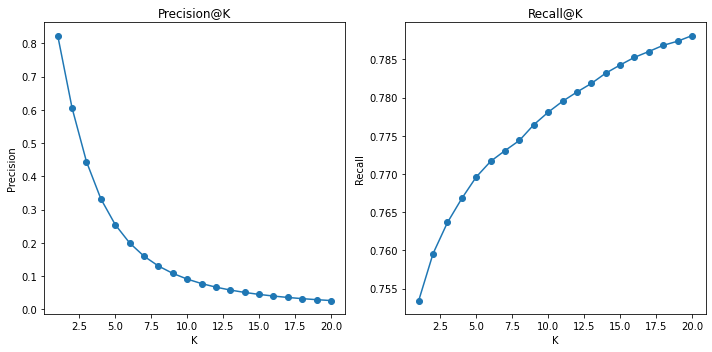

In [50]:
precision_data = table_metrics[table_metrics['metric'].str.contains('precision')]
recall_data = table_metrics[table_metrics['metric'].str.contains('recall')]


precision_mean = precision_data['mean']
recall_mean = recall_data['mean']

precision_k = [int(x.split('@')[-1]) for x in precision_data['metric']]
recall_k = [int(x.split('@')[-1]) for x in recall_data['metric']]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(precision_k, precision_mean, marker='o')
plt.title('Precision@K')
plt.xlabel('K')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(recall_k, recall_mean, marker='o')
plt.title('Recall@K')
plt.xlabel('K')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

Second option: we saved the amount of masked items when creating a masked test sample --> the гипотеза такая что we should check the precision and recall @ k with additional paramemter as the num of masked items and to check that the items to pred are surely were suggested in predicted recommendations

In [53]:
evaluation_df_data_tables.head()

order_id                                    original_basket  \
0  300652850781                                [647, 73255, 42672]   
1  300652850783                         [33142, 72133, 647, 59318]   
2  300652850784                          [647, 47115, 1642, 69937]   
3  300652850787  [63727, 18291, 34804, 647, 36871, 63032, 48473...   
4  300652850789    [647, 16591, 73541, 83219, 68678, 85386, 89167]   

   num_to_mask lists_to_pred  \
0            1           647   
1            1         72133   
2            1         47115   
3            2         63032   
4            2         16591   

                                       masked_basket  \
0                                       [647, 73255]   
1                                [72133, 59318, 647]   
2                                [47115, 69937, 647]   
3  [63032, 36871, 82517, 63727, 64579, 48473, 647...   
4                [16591, 85386, 68678, 73541, 83219]   

                                               preds  
0  [647, 731, 173, 76719, 76709, 61986, 49623, 33...  
1  [647, 59310, 79165, 173, 24910, 49623, 185, 56...  
2  [647, 65377, 69936, 65375, 78710, 91584, 36296...  
3  [647, 731, 18518, 49623, 17823, 75717, 26796, ...  
4  [647, 731, 488, 16306, 730, 22189, 20542, 4320...

In [54]:
def precision_recall_at_fixed_masked_k(masked_basket, preds, original_basket, masked_k):
    precision = []
    recall = []
    masked_and_preds = masked_basket.copy()
    for k in range(1, masked_k):
        masked_and_preds.extend(preds[:k])  # adding k predictions to masked basket
        intersection = len(set(masked_and_preds).intersection(set(original_basket)))
        precision.append(intersection / len(masked_and_preds))
        recall.append(intersection / len(original_basket))
    return precision, recall

In [55]:
def calculate_fixed_k_metrics(df):
    for index, row in evaluation_df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = row['preds']
        masked_k = row['num_to_mask']
    

        precisions, recalls =precision_recall_at_fixed_masked_k(masked_basket, preds, original_basket, masked_k)
        for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
            df.at[index, f'precision@{k}'] = precision
            df.at[index, f'recall@{k}'] = recall

In [56]:
calculate_fixed_k_metrics(evaluation_df)

In [192]:
# evaluation_df.dropna()

In [191]:
# evaluation_df

- есть какой-то вонючий айтем 647, который все портит при подсчете метрик (есть в каждом заказе, на первом месте по потенциальному предсказанию, поэтому все fixed @ k precision рассчеты чаще оказываются нулевыми) 

Top-N items scores: 

Would recommeding most popular items win vs EASE? 

In [57]:
top_rec_items = train_data.good_foreign_id.value_counts()[:20].index.tolist()

In [58]:
train_data.good_foreign_id.value_counts(normalize = True)

647      0.126118
731      0.009941
609      0.005102
173      0.004648
22658    0.004423
           ...   
74334    0.000002
91525    0.000002
74341    0.000002
54314    0.000002
75977    0.000002
Name: good_foreign_id, Length: 10452, dtype: float64

In [59]:
tt = pd.DataFrame(train_data.groupby(['order_id']).agg(list).good_foreign_id).reset_index()

In [62]:
def has_647(row):
    return 647 in row['good_foreign_id']

filtered_df = tt.loc[tt.apply(has_647, axis=1)]

len(filtered_df) / len(tt)

0.9297072411240715

In [63]:
evaluation_df_data_tables.head()

order_id                                    original_basket  \
0  300652850781                                [647, 73255, 42672]   
1  300652850783                         [33142, 72133, 647, 59318]   
2  300652850784                          [647, 47115, 1642, 69937]   
3  300652850787  [63727, 18291, 34804, 647, 36871, 63032, 48473...   
4  300652850789    [647, 16591, 73541, 83219, 68678, 85386, 89167]   

   num_to_mask lists_to_pred  \
0            1           647   
1            1         72133   
2            1         47115   
3            2         63032   
4            2         16591   

                                       masked_basket  \
0                                       [647, 73255]   
1                                [72133, 59318, 647]   
2                                [47115, 69937, 647]   
3  [63032, 36871, 82517, 63727, 64579, 48473, 647...   
4                [16591, 85386, 68678, 73541, 83219]   

                                               preds  
0  [647, 731, 173, 76719, 76709, 61986, 49623, 33...  
1  [647, 59310, 79165, 173, 24910, 49623, 185, 56...  
2  [647, 65377, 69936, 65375, 78710, 91584, 36296...  
3  [647, 731, 18518, 49623, 17823, 75717, 26796, ...  
4  [647, 731, 488, 16306, 730, 22189, 20542, 4320...

In [64]:
def calculate_precision_recall_top_n_items(df, list_of_top_n):
    for index, row in df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = list_of_top_n #top_item_list 
        
        precisions, recalls = precision_recall_at_k(masked_basket, preds, original_basket)
        
        for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
            df.at[index, f'precision@{k}'] = precision
            df.at[index, f'recall@{k}'] = recall

In [65]:
calculate_precision_recall_top_n_items(evaluation_df_data_tables,top_rec_items )

In [66]:
evaluation_df_data_tables.head(3)

order_id             original_basket  num_to_mask lists_to_pred  \
0  300652850781         [647, 73255, 42672]            1           647   
1  300652850783  [33142, 72133, 647, 59318]            1         72133   
2  300652850784   [647, 47115, 1642, 69937]            1         47115   

         masked_basket                                              preds  \
0         [647, 73255]  [647, 731, 173, 76719, 76709, 61986, 49623, 33...   
1  [72133, 59318, 647]  [647, 59310, 79165, 173, 24910, 49623, 185, 56...   
2  [47115, 69937, 647]  [647, 65377, 69936, 65375, 78710, 91584, 36296...   

   precision@1  recall@1  precision@2  recall@2  ...  precision@16  recall@16  \
0     0.666667  0.666667          0.4  0.666667  ...      0.014493   0.666667   
1     0.750000  0.750000          0.5  0.750000  ...      0.021583   0.750000   
2     0.750000  0.750000          0.5  0.750000  ...      0.021583   0.750000   

   precision@17  recall@17  precision@18  recall@18  precision@19  recall@19  \
0      0.012903   0.666667      0.011561   0.666667      0.010417   0.666667   
1      0.019231   0.750000      0.017241   0.750000      0.015544   0.750000   
2      0.019231   0.750000      0.017241   0.750000      0.015544   0.750000   

   precision@20  recall@20  
0      0.009434   0.666667  
1      0.014085   0.750000  
2      0.014085   0.750000  

[3 rows x 46 columns]

In [67]:
table_metrics = evaluation_df_data_tables.describe().T.reset_index().rename({'index': 'metric'}, axis = 1)

In [68]:
table_metrics = table_metrics[['metric', 'mean', 'std']].drop(index = [0,1])

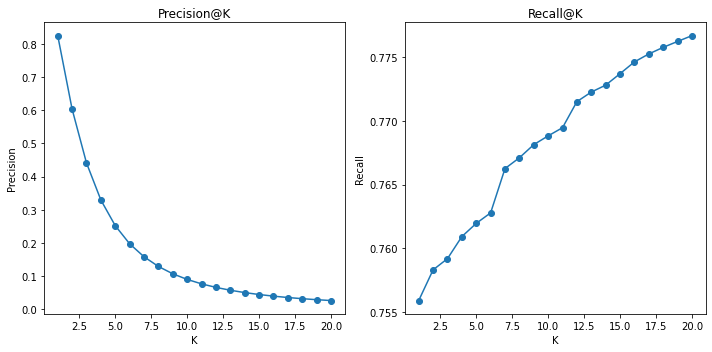

In [69]:
precision_data = table_metrics[table_metrics['metric'].str.contains('precision')]
recall_data = table_metrics[table_metrics['metric'].str.contains('recall')]


precision_mean = precision_data['mean']
recall_mean = recall_data['mean']

precision_k = [int(x.split('@')[-1]) for x in precision_data['metric']]
recall_k = [int(x.split('@')[-1]) for x in recall_data['metric']]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(precision_k, precision_mean, marker='o')
plt.title('Precision@K')
plt.xlabel('K')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(recall_k, recall_mean, marker='o')
plt.title('Recall@K')
plt.xlabel('K')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()